<a href="https://colab.research.google.com/github/Ashraf1292/Thesis-Fake_jobs-/blob/main/tuned_version_XGBoost_23_march.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
from imblearn.combine import SMOTETomek
from scipy.stats import uniform, randint
import xgboost as xgb
import shap

# Download necessary NLTK resources properly with error handling
print("Downloading necessary NLTK resources...")
nltk_resources = ['punkt', 'stopwords', 'wordnet']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
        print(f"{resource} already downloaded")
    except LookupError:
        print(f"Downloading {resource}...")
        nltk.download(resource, quiet=True)
        print(f"{resource} download complete")

# Step 1: Data Preprocessing
print("Step 1: Loading and preprocessing data...")
# Load dataset
df = pd.read_csv('fake_job_postings.csv')
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['fraudulent'].value_counts()}")

# Function to preprocess text
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    try:
        # Try NLTK tokenization
        tokens = word_tokenize(text)
    except:
        # Fallback to simple tokenization if NLTK fails
        print("Falling back to simple tokenization.")
        tokens = text.split()
    try:
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    except Exception as e:
        print(f"Error in stopwords or lemmatization: {e}")
        # Return simple processed text if stopwords/lemmatization fails
        return text
    return ' '.join(tokens)

# Merge text fields and preprocess
print("Merging and preprocessing text fields...")
df['combined_text'] = (
    df['company_profile'].fillna('') + ' ' +
    df['description'].fillna('') + ' ' +
    df['requirements'].fillna('')
)

# Apply preprocessing to the combined text
df['processed_text'] = df['combined_text'].apply(preprocess_text)

# Remove rows with empty processed text
df = df[df['processed_text'].str.strip() != '']
print(f"Dataset shape after preprocessing: {df.shape}")

# Explore text length distribution
df['text_length'] = df['processed_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='fraudulent', bins=50, alpha=0.7)
plt.title('Text Length Distribution by Class')
plt.xlabel('Processed Text Length')
plt.xlim(0, 10000)  # Adjust limits as needed
plt.savefig('text_length_distribution.png')
plt.close()


Streaming output truncated to the last 5000 lines.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple t

<ipython-input-1-bc8433aeafe9>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['processed_text'].apply(len)


In [2]:
# Step 2: Feature Engineering
print("\nStep 2: Feature Engineering...")
# TF-IDF Vectorization with n-grams
print("Performing TF-IDF vectorization with n-grams...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.85,
    ngram_range=(1, 2)  # Add bigrams for better feature representation
)
X = tfidf_vectorizer.fit_transform(df['processed_text'])
y = df['fraudulent']
print(f"Feature matrix shape: {X.shape}")

# Adding additional metadata features if available
# Uncomment and modify if you have these columns
"""
# Extract additional features
additional_features = []

# Company name provided? (Missing company name might be suspicious)
if 'company_profile' in df.columns:
    additional_features.append(df['company_profile'].notna().astype(int).values.reshape(-1, 1))

# Experience required?
if 'required_experience' in df.columns:
    additional_features.append(df['required_experience'].notna().astype(int).values.reshape(-1, 1))

# Has salary range?
if 'salary_range' in df.columns:
    additional_features.append(df['salary_range'].notna().astype(int).values.reshape(-1, 1))

# Employment type provided?
if 'employment_type' in df.columns:
    additional_features.append(df['employment_type'].notna().astype(int).values.reshape(-1, 1))

# If we have additional features, add them to X
if additional_features:
    additional_features = np.hstack(additional_features)
    # Convert X to dense format first as it's likely still sparse
    X_dense = X.toarray()
    X = np.hstack((X_dense, additional_features))
    print(f"Feature matrix shape after adding metadata: {X.shape}")
"""

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Step 2: Feature Engineering...
Performing TF-IDF vectorization with n-grams...
Feature matrix shape: (17879, 5000)
Training set: (14303, 5000)
Test set: (3576, 5000)


In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Step 3: Handle Class Imbalance with partial resampling
print("\nStep 3: Handling class imbalance with partial resampling...")
print(f"Class distribution before resampling:\n{np.bincount(y_train)}")

# First apply SMOTE with a moderate ratio
# Target ratio is 1:3 (minority:majority)
majority_count = (y_train == 0).sum()
minority_count = (y_train == 1).sum()
target_ratio = 3  # Aim for 1:3 ratio
target_minority_count = majority_count / target_ratio

# Calculate sampling_strategy to achieve desired ratio
sampling_strategy = min(1.0, target_minority_count / minority_count)

# Apply SMOTE with calculated sampling_strategy
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f"Class distribution after resampling:\n{np.bincount(y_resampled)}")
print(f"Resampled training set: {X_resampled.shape}")


Step 3: Handling class imbalance with partial resampling...
Class distribution before resampling:
[13611   692]
Class distribution after resampling:
[13611 13611]
Resampled training set: (27222, 5000)


In [9]:
# Step 4: Model Training with Hyperparameter Tuning
print("\nStep 4: Training XGBoost model with hyperparameter tuning...")

# Define parameter distribution for randomized search
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'scale_pos_weight': [1, 3, 5]  # Try different weights despite resampling
}

# Initialize base model
base_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42
)

# Initialize RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=25,  # Number of parameter settings sampled
    scoring='f1',  # Optimize for F1 score (balances precision and recall)
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV
search.fit(X_resampled, y_resampled)

# Get best parameters and model
best_params = search.best_params_
print(f"Best parameters: {best_params}")
xgb_model = search.best_estimator_



Step 4: Training XGBoost model with hyperparameter tuning...
Fitting 5 folds for each of 25 candidates, totalling 125 fits


KeyboardInterrupt: 

In [10]:
# Step 4: Model Training with Simpler Tuning Approach
print("\nStep 4: Training XGBoost model with simpler parameter tuning...")

# Split the resampled data for quick validation
X_train_res, X_val_res, y_train_res, y_val_res = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Try a few pre-selected parameter combinations
param_sets = [
    # Set 1: Balanced
    {
        'max_depth': 4,
        'learning_rate': 0.1,
        'n_estimators': 200,
        'scale_pos_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    },
    # Set 2: Focus on minority class
    {
        'max_depth': 5,
        'learning_rate': 0.05,
        'n_estimators': 300,
        'scale_pos_weight': 3,
        'subsample': 0.7,
        'colsample_bytree': 0.7
    },
    # Set 3: More aggressive for minority class
    {
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 250,
        'scale_pos_weight': 5,
        'subsample': 0.8,
        'colsample_bytree': 0.6
    }
]

best_f1 = 0
best_model = None

for i, params in enumerate(param_sets):
    print(f"Training model with parameter set {i+1}...")
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
        **params
    )

    model.fit(X_train_res, y_train_res)

    # Evaluate
    val_preds = model.predict(X_val_res)
    val_f1 = f1_score(y_val_res, val_preds)
    print(f"Validation F1 score: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model = model

# Use the best model found
xgb_model = best_model
print(f"Best validation F1 score: {best_f1:.4f}")


Step 4: Training XGBoost model with simpler parameter tuning...
Training model with parameter set 1...
Validation F1 score: 0.9809
Training model with parameter set 2...
Validation F1 score: 0.9732
Training model with parameter set 3...
Validation F1 score: 0.9868
Best validation F1 score: 0.9868



Step 5: Evaluating model performance...

Classification Report with Default Threshold:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3403
           1       0.66      0.85      0.74       173

    accuracy                           0.97      3576
   macro avg       0.83      0.91      0.86      3576
weighted avg       0.98      0.97      0.97      3576



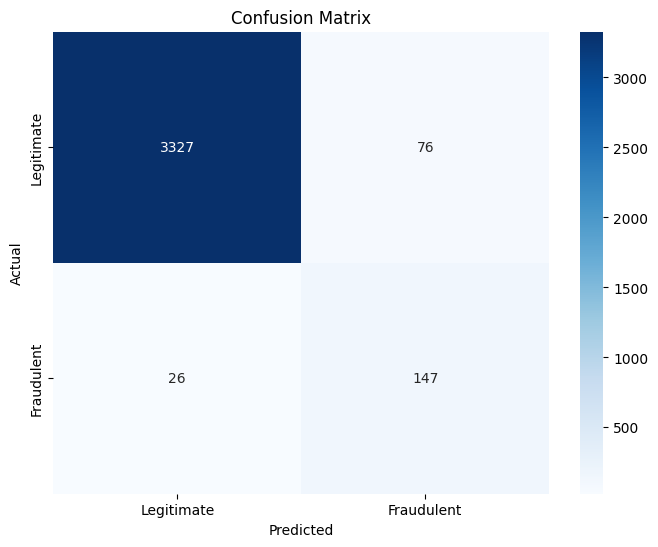

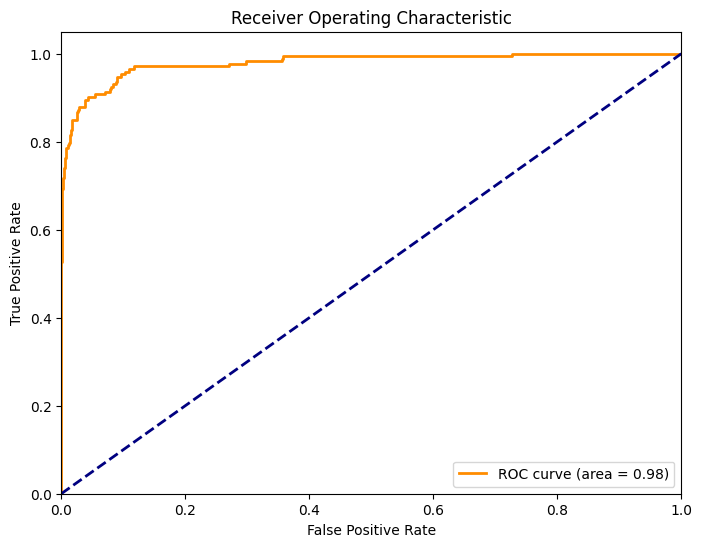

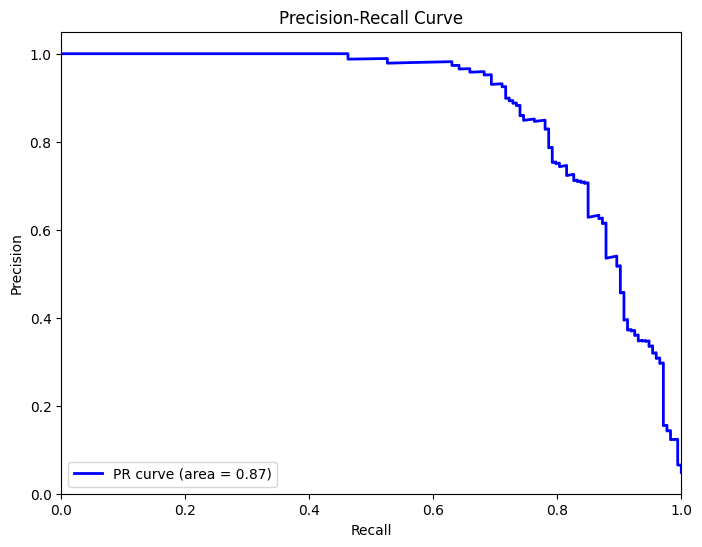

In [11]:
# Step 5: Model Evaluation
print("\nStep 5: Evaluating model performance...")
# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Classification metrics
print("\nClassification Report with Default Threshold:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('precision_recall_curve.png')
plt.show()



Step 6: Finding optimal threshold...
Best threshold: 0.7000000000000002

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.83      0.78      0.81       173

    accuracy                           0.98      3576
   macro avg       0.91      0.89      0.90      3576
weighted avg       0.98      0.98      0.98      3576



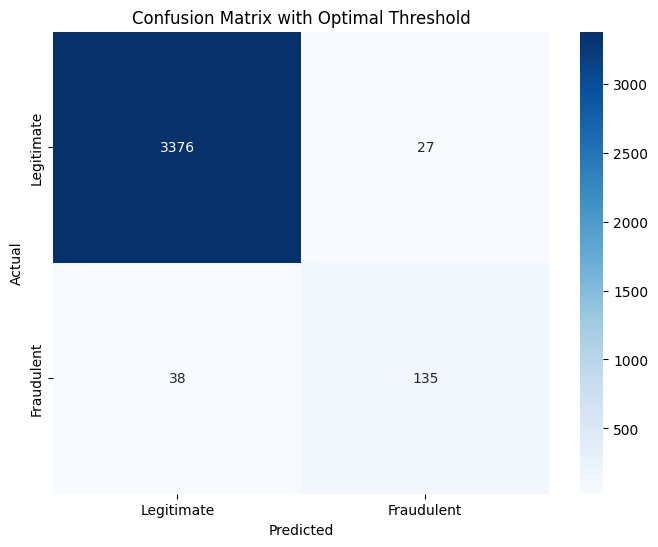

In [12]:
# Step 6: Find optimal threshold
print("\nStep 6: Finding optimal threshold...")
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)

# Find threshold that maximizes F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best threshold: {best_threshold}")

# Apply best threshold
y_pred_best = (y_pred_proba >= best_threshold).astype(int)
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_best))

# Updated confusion matrix with optimal threshold
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Optimal Threshold')
plt.savefig('confusion_matrix_optimal.png')
plt.show()